# Bi-LSTM

y_train shape: (19090, 35, 43)
y_test shape: (4775, 35, 43)
Epoch 1/20
478/478 ━━━━━━━━━━━━━━━━━━━━ 182s 365ms/step - accuracy: 0.0551 - loss: 4.8070 - val_accuracy: 0.2639 - val_loss: 1.8516
Epoch 2/20
478/478 ━━━━━━━━━━━━━━━━━━━━ 167s 348ms/step - accuracy: 0.2927 - loss: 1.5893 - val_accuracy: 0.4751 - val_loss: 1.0525
Epoch 3/20
478/478 ━━━━━━━━━━━━━━━━━━━━ 202s 349ms/step - accuracy: 0.4556 - loss: 1.0578 - val_accuracy: 0.5445 - val_loss: 0.6103
Epoch 4/20
478/478 ━━━━━━━━━━━━━━━━━━━━ 203s 351ms/step - accuracy: 0.5231 - loss: 0.8438 - val_accuracy: 0.5676 - val_loss: 0.4880
Epoch 5/20
478/478 ━━━━━━━━━━━━━━━━━━━━ 168s 352ms/step - accuracy: 0.5506 - loss: 0.5336 - val_accuracy: 0.5754 - val_loss: 0.3771
Epoch 6/20
478/478 ━━━━━━━━━━━━━━━━━━━━ 201s 350ms/step - accuracy: 0.5654 - loss: 0.3727 - val_accuracy: 0.5803 - val_loss: 0.3134
Epoch 7/20
478/478 ━━━━━━━━━━━━━━━━━━━━ 203s 353ms/step - accuracy: 0.5694 - loss: 0.3567 - val_accuracy: 0.5696 - val_loss: 0.3560
Epoch 8/20
478/4

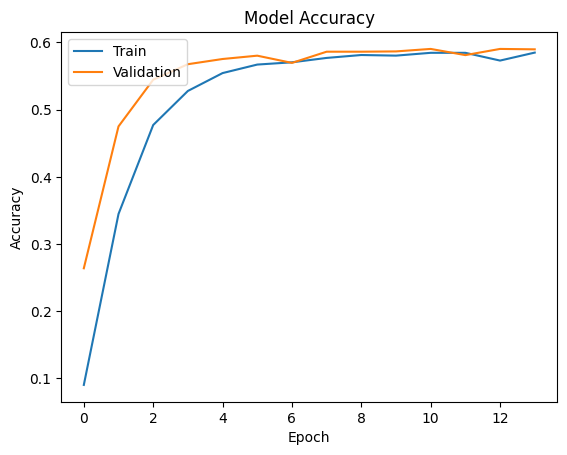

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
from numpy import percentile

def load_data(file_path):
    sentences = []
    sentence = []
    with open(file_path, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                if sentence:
                    sentences.append(sentence)
                    sentence = []
            else:
                word, tag = line.split('\t')
                sentence.append((word, tag))
        if sentence:
            sentences.append(sentence)
    return sentences

train_sentences = load_data(r'/content/preprocessed_dataset_train.txt')
test_sentences = load_data(r'/content/preprocessed_dataset_test.txt')

word_counts = {}

tag_set = {'PAD'}

for sentence in train_sentences:
    for word, tag in sentence:
        word_counts[word] = word_counts.get(word, 0) + 1
        tag_set.add(tag)

vocab = ['<PAD>', '<UNK>'] + [word for word, count in word_counts.items() if count >= 2]
tag_list = sorted(tag_set)

word2idx = {word: idx for idx, word in enumerate(vocab)}
tag2idx = {tag: idx for idx, tag in enumerate(tag_list)}

def encode(sentences, word2idx, tag2idx):
    X = []
    y = []
    for sentence in sentences:
        x_seq = []
        y_seq = []
        for word, tag in sentence:
            x_seq.append(word2idx.get(word, word2idx['<UNK>']))
            y_seq.append(tag2idx[tag])
        X.append(x_seq)
        y.append(y_seq)
    return X, y

X_train, y_train = encode(train_sentences, word2idx, tag2idx)
X_test, y_test = encode(test_sentences, word2idx, tag2idx)


pad_tag_idx = tag2idx['PAD']

max_len = int(percentile([len(s) for s in train_sentences], 95))

X_train = pad_sequences(X_train, maxlen=max_len, padding='post', value=word2idx['<PAD>'])
X_test = pad_sequences(X_test, maxlen=max_len, padding='post', value=word2idx['<PAD>'])
y_train = pad_sequences(y_train, maxlen=max_len, padding='post', value=pad_tag_idx)
y_test = pad_sequences(y_test, maxlen=max_len, padding='post', value=pad_tag_idx)

num_tags = len(tag_list)

y_train_flat = y_train.flatten()
y_train_categorical = utils.to_categorical(y_train_flat, num_classes=num_tags)
y_train = y_train_categorical.reshape(y_train.shape[0], y_train.shape[1], num_tags)


y_test_flat = y_test.flatten()
y_test_categorical = utils.to_categorical(y_test_flat, num_classes=num_tags)
y_test = y_test_categorical.reshape(y_test.shape[0], y_test.shape[1], num_tags)


print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

mask = y_train_flat != tag2idx['PAD']


from sklearn.utils.class_weight import compute_class_weight
classes = np.unique(y_train_flat[mask])
class_weights = compute_class_weight('balanced', classes=classes, y=y_train_flat[mask])
class_weight_dict = {cls: weight for cls, weight in zip(classes, class_weights)}


sample_weights = np.zeros_like(y_train_flat, dtype=np.float32)
sample_weights[mask] = [class_weight_dict[cls] for cls in y_train_flat[mask]]
sample_weights = sample_weights.reshape(y_train.shape[0], y_train.shape[1])


def build_model(vocab_size, num_tags, embedding_dim=128, lstm_units=256):
    model = models.Sequential()
    model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, mask_zero=True))


    model.add(layers.Bidirectional(
        layers.LSTM(lstm_units, return_sequences=True, kernel_regularizer='l2')
    ))
    model.add(layers.Dropout(0.7))

    model.add(layers.Dense(num_tags, activation='softmax'))
    return model

model = build_model(len(vocab), num_tags)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=20,
    validation_split=0.2,
    callbacks=[early_stopping],
    sample_weight=sample_weights,
    verbose=1
)

def flatten_preds(y_true, y_pred):
    y_true_flat = np.argmax(y_true.reshape(-1, num_tags), axis=1)
    y_pred_flat = np.argmax(y_pred.reshape(-1, num_tags), axis=1)

    mask = y_true_flat != tag2idx['PAD']
    return y_true_flat[mask], y_pred_flat[mask]

y_pred = model.predict(X_test)
y_true_flat, y_pred_flat = flatten_preds(y_test, y_pred)

valid_tags = np.unique(y_true_flat)
valid_tag_names = [tag_list[idx] for idx in valid_tags]

print(classification_report(
    y_true_flat,
    y_pred_flat,
    labels=valid_tags,
    target_names=valid_tag_names
))


print("\nWeighted F1 Score:", f1_score(y_true_flat, y_pred_flat, average='weighted'))
print("Macro F1 Score:", f1_score(y_true_flat, y_pred_flat, average='macro'))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [2]:
print("\nConfusion Matrix:")
print(confusion_matrix(y_true_flat, y_pred_flat))


Confusion Matrix:
[[ 112    0    0 ...    0    0    0]
 [   0 3161    0 ...    0    0    0]
 [   0    0 4758 ...    0    0    1]
 ...
 [   0    0    0 ...    9    0    0]
 [   0    0    0 ...    0  215    0]
 [   0    0    0 ...    0    0  386]]
